# Tuning a `multi_match` `most_fields` query

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import os
import sys

from copy import deepcopy
from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [3]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev, evaluate_mrr100_dev_templated, optimize_query_mrr100, optimize_query_mrr100_templated
from qopt.optimize import Config

In [4]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
# es = Elasticsearch('http://localhost:9200')
es = Elasticsearch('http://35.246.228.72:9200')

# set the parallelization parameter `max_concurrent_searches` for the Rank Evaluation API calls
max_concurrent_searches = 30

index = 'msmarco-document.doc2query'
template_id = 'query'

# base template for tuning
base_templates = [{
    "id": template_id,
    "template": {
        "lang": "mustache",
        "source": { "query": {} }
    }
}]

## Experiments

### Base fields + bigrams

In [5]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": "most_fields",
    "query": "{{query_string}}",
    "tie_breaker": "{{tie_breaker}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "title.bigrams^{{title_bigrams|boost}}",
        "body^{{body|boost}}",
        "body.bigrams^{{body_bigrams|boost}}",
    ]
}

In [6]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'tie_breaker': 0.0,
    'url|boost': 1.0,
    'title|boost': 1.0,
    'title_bigrams|boost': 1.0,
    'body|boost': 1.0,
    'body_bigrams|boost': 1.0,
})

Evaluation with: MRR@100
Score: 0.2582
CPU times: user 2.11 s, sys: 836 ms, total: 2.94 s
Wall time: 5min 38s


In [7]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'tie_breaker': { 'low': 0.0, 'high': 1.0 },
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'title_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:01:04 (remains: 0:52:23)
   | 0.2249 (best: 0.2249) - {'tie_breaker': 0.8157939366982153, 'url|boost': 3.9954646292048634, 'title|boost': 4.557109907313372, 'title_bigrams|boost': 8.093459660514183, 'body|boost': 1.840339382703359, 'body_bigrams|boost': 5.935625251762473}
 > iteration 2/50, took 0:01:11 (remains: 0:57:14)
   | 0.2576 (best: 0.2576) - {'tie_breaker': 0.5867319087515847, 'url|boost': 4.414120993316616, 'title|boost': 6.686691158763884, 'title_bigrams|boost': 2.5108790596299007, 'body|boost': 9.237054530476486, 'body_bigrams|boost': 9.344459164942355}
 > iteration 3/50, took 0:01:10 (remains: 0:55:22)
   | 0.2531 (best: 0.2576) - {'tie_breaker': 0.4091740744097513, 'url|boost': 5.001236871428584, 'title|boost': 2.1338831385091312, 'title_bigrams|boost': 6.85572015298292, 'body|boost': 5.0

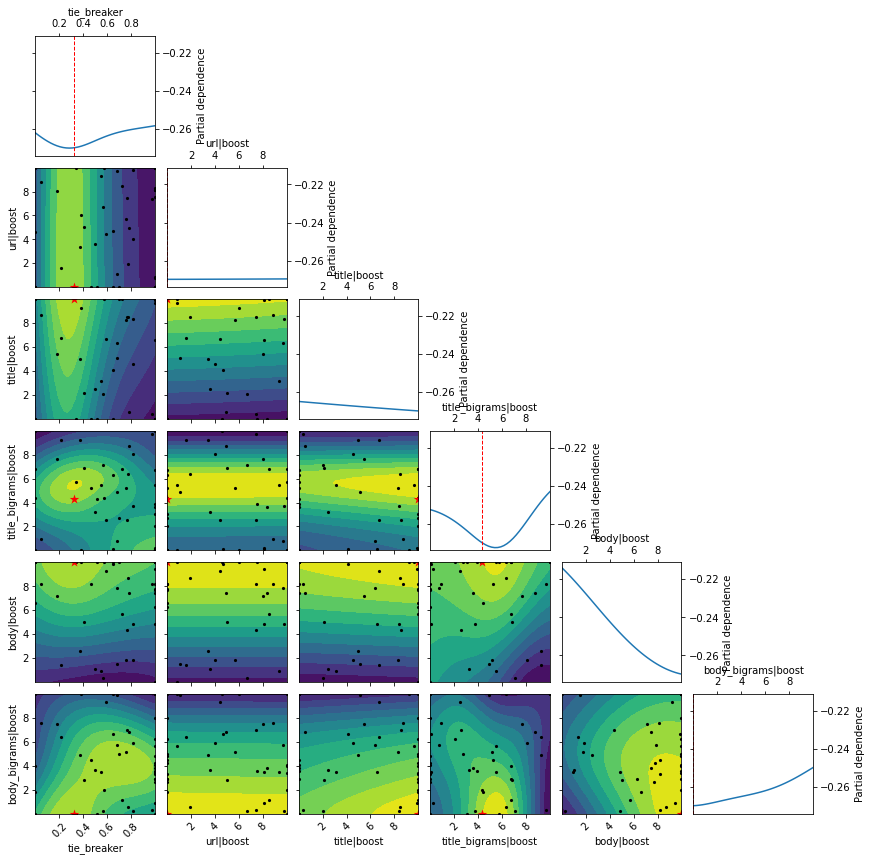

In [8]:
_ = plot_objective(metadata, sample_source='result')

In [9]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.2986
CPU times: user 2.19 s, sys: 869 ms, total: 3.06 s
Wall time: 5min 34s


In [10]:
final_params

{'tie_breaker': 0.3238680521634652,
 'url|boost': 0.0,
 'title|boost': 10.0,
 'title_bigrams|boost': 4.303754044910785,
 'body|boost': 10.0,
 'body_bigrams|boost': 0.0}

### Base fields + expansions

In [11]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": "most_fields",
    "query": "{{query_string}}",
    "tie_breaker": "{{tie_breaker}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "body^{{body|boost}}",
        "expansions^{{expansions|boost}}",
    ]
}

In [12]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'tie_breaker': 0.0,
    'url|boost': 1.0,
    'title|boost': 1.0,
    'body|boost': 1.0,
    'expansions|boost': 1.0,
})

Evaluation with: MRR@100
Score: 0.3229
CPU times: user 2.35 s, sys: 823 ms, total: 3.17 s
Wall time: 3min


In [13]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'tie_breaker': { 'low': 0.0, 'high': 1.0 },
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:00:41 (remains: 0:34:01)
   | 0.3041 (best: 0.3041) - {'tie_breaker': 0.44101279243563896, 'url|boost': 8.179152140707856, 'title|boost': 9.348216201697388, 'body|boost': 3.1111256848561, 'expansions|boost': 5.820285692633487}
 > iteration 2/50, took 0:00:40 (remains: 0:32:47)
   | 0.2954 (best: 0.3041) - {'tie_breaker': 0.2429349961942187, 'url|boost': 4.53765573505291, 'title|boost': 4.892963957732781, 'body|boost': 1.4445863936865224, 'expansions|boost': 1.5438614449356471}
 > iteration 3/50, took 0:00:38 (remains: 0:30:06)
   | 0.2973 (best: 0.3041) - {'tie_breaker': 0.3631391935285337, 'url|boost': 1.368736828110956, 'title|boost': 5.8743548958754985, 'body|boost': 7.267561512069324, 'expansions|boost': 2.7883907976833338}
 > iteration 4/50, took 0:00:37 (remains: 0:29:04)
   | 0.3010 (best: 0.304

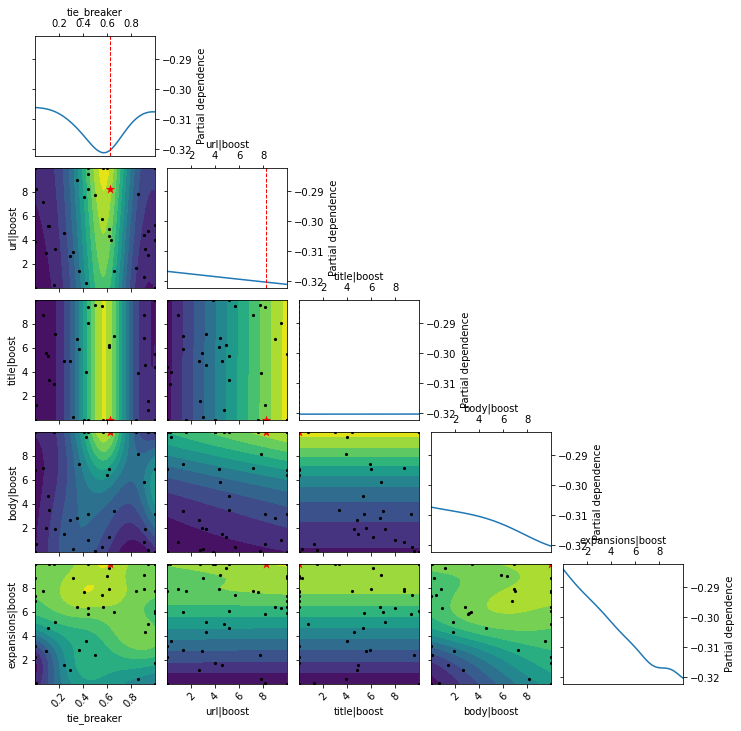

In [14]:
_ = plot_objective(metadata, sample_source='result')

In [15]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.3347
CPU times: user 2.32 s, sys: 735 ms, total: 3.05 s
Wall time: 3min 15s


In [16]:
final_params

{'tie_breaker': 0.6261160256825453,
 'url|boost': 8.250770299995436,
 'title|boost': 0.0,
 'body|boost': 10.0,
 'expansions|boost': 10.0}

### Base fields + expansions + bigrams

In [17]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": "most_fields",
    "query": "{{query_string}}",
    "tie_breaker": "{{tie_breaker}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "title.bigrams^{{title_bigrams|boost}}",
        "body^{{body|boost}}",
        "body.bigrams^{{body_bigrams|boost}}",
        "expansions^{{expansions|boost}}",
        "expansions.bigrams^{{expansions_bigrams|boost}}"
    ]
}

In [18]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'tie_breaker': 0.0,
    'url|boost': 1.0,
    'title|boost': 1.0,
    'title_bigrams|boost': 1.0,
    'body|boost': 1.0,
    'body_bigrams|boost': 1.0,
    'expansions|boost': 1.0,
    'expansions_bigrams|boost': 1.0
})

Evaluation with: MRR@100
Score: 0.3240
CPU times: user 2.76 s, sys: 695 ms, total: 3.45 s
Wall time: 7min 9s


In [ ]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'tie_breaker': { 'low': 0.0, 'high': 1.0 },
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'title_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:01:25 (remains: 1:09:28)
   | 0.2964 (best: 0.2964) - {'tie_breaker': 0.6351705475913622, 'url|boost': 6.904794777535361, 'title|boost': 8.809721456019464, 'title_bigrams|boost': 6.05044225112043, 'body|boost': 1.1814161923728308, 'body_bigrams|boost': 8.688432095353544, 'expansions|boost': 8.863759488364554, 'expansions_bigrams|boost': 6.190185025048766}
 > iteration 2/50, took 0:01:22 (remains: 1:06:10)
   | 0.3060 (best: 0.3060) - {'tie_breaker': 0.4169055697415176, 'url|boost': 1.8850940741027107, 'title|boost': 8.436482890868014, 'title_bigrams|boost': 2.1180638324384664, 'body|boost': 0.2816059087712975, 'body_bigrams|boost': 6.391338563203213, 'expansions|boost': 7.343419497664795, 'expansions_bigrams|boost': 1.0139117487849794}
 > iteration 3/50, took 0:01:24 (remains: 1:06:23)
   | 0.3079 (bes

In [ ]:
_ = plot_objective(metadata, sample_source='result')

In [ ]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

In [ ]:
final_params